# Stable Baselines 3 Foundations : data collection

## Outlook



In this notebook, we will start from the central interaction loop in reinforcement learning (RL) and focus on how data collection is performed in Stable Baselines 3. A key concern is that the interaction loop is at the heart of the RL process, deep inside any RL library, so we would like users of the library to be able to perform additional processes in this loop without touching its code. We will see that there are two possible mechanisms for doing this: wrappers and callbacks. We will present them and discuss there relative merits.

Then we will present how data collection is performed in Stable Baselines3.


## Install Dependencies and Stable Baselines 3 Using Pip

The list of full dependencies can be found in the [README](https://github.com/DLR-RM/stable-baselines3).


```
pip install stable-baselines3[extra]
```

In [ ]:
!apt-get install ffmpeg freeglut3-dev xvfb  # For visualization

In [ ]:
! pip install stable-baselines3

## The core interaction loop

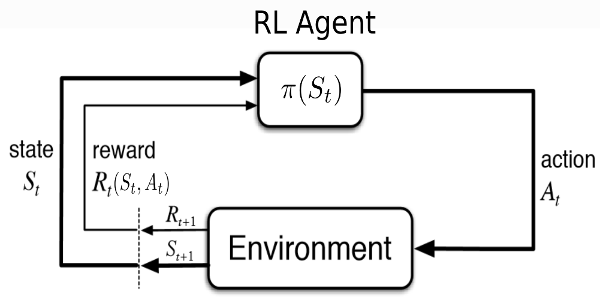

The figure above is the standard figure to present the interaction between an agent and its environment in RL. We first explain how to get an environment and an agent.

### Gym environments

In most RL libraries, the environment is represented as an object which follows the [gym interface](https://stable-baselines3.readthedocs.io/en/master/guide/custom_env.html). This interface is quite simple to use.
It provides to this user mainly three methods:
- `reset()` called at the beginning of an episode, it returns an observation
- `step(action)` called to perform an action in the environment, it returns the next observation, the immediate reward, whether the episode is over and a place holder for any additional information that one may need
- (Optional) `render(method='human')` provding a visualization of the agent in action. Note that graphical interfaces do not work inside google colab (the code is run from an external machine), so we cannot use it directly here (we have to rely on `method='rbg_array'` to retrieve an image of the scene...

Under the hood, it also contains two useful properties:
- `observation_space` which is one of the gym spaces (`Discrete`, `Box`, ...) and describes the type and shape of the observation
- `action_space` which is also a gym space object that describes the action space, i.e. the type or list of actions that can be taken

The best way to learn about gym spaces is to look at the [source code](https://github.com/openai/gym/tree/master/gym/spaces), but you need to know at least the main ones:
- `gym.spaces.Box`: A (possibly unbounded) box in $R^n$. Specifically, a Box represents the Cartesian product of n closed intervals. Each interval has the form of one of [a, b], (-oo, b], [a, oo), or (-oo, oo). Example: A 1D-Vector or an image observation can be described with the Box space.
```python
# Example for using image as input:
observation_space = spaces.Box(low=0, high=255, shape=(HEIGHT, WIDTH, N_CHANNELS), dtype=np.uint8)
```                                       

- `gym.spaces.Discrete`: A discrete space in $\{ 0, 1, \dots, n-1 \}$
  Example: if you have two actions ("left" and "right") you can represent your action space using `Discrete(2)`, the first action will be 0 and the second 1.

You can find a list of available environments [here](https://gym.openai.com/envs/#classic_control).

It is also recommended to check the [source code](https://github.com/openai/gym) to learn more about the observation and action space of each environment, as gym does not have a proper documentation.
Not all algorithms can work with all action spaces, you can find more on this in the [recap table](https://stable-baselines3.readthedocs.io/en/master/guide/algos.html)

Let us import gym (and numpy)


In [ ]:
import gym
import numpy as np

### Stable Baselines 3 agents

After seeing environments, let us now look at agents.

In Stable Baselines 3, the agent consists of an RL algorithm.

The first thing you need to import is the RL agent, check the [documentation](https://github.com/DLR-RM/rl-baselines3-zoo#current-collection-100-trained-agents) to know what you can use on which problem

In [ ]:
from stable_baselines3 import PPO, A2C, SAC, TD3, DQN

The next thing you need to import is the policy class that will be used to create the networks (for the policy/value functions).
This step is optional as you can directly use strings in the constructor: 

```PPO("MlpPolicy", env)``` instead of ```PPO(MlpPolicy, env)```

Note that some algorithms like `SAC` have their own `MlpPolicy`, that's why using string for the policy is the recommended option.

In [ ]:
from stable_baselines3.ppo.policies import MlpPolicy

## Create the Gym env and instantiate the agent

For this example, we will use CartPole environment, a classic control problem.

"A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The system is controlled by applying a force of +1 or -1 to the cart. The pendulum starts upright, and the goal is to prevent it from falling over. A reward of +1 is provided for every timestep that the pole remains upright. "

Cartpole environment: [https://gym.openai.com/envs/CartPole-v1/](https://gym.openai.com/envs/CartPole-v1/)

![Cartpole](https://cdn-images-1.medium.com/max/1143/1*h4WTQNVIsvMXJTCpXm_TAw.gif)


We chose the MlpPolicy because the observation of the CartPole task is a feature vector, not images.

The type of action to use (discrete/continuous) will be automatically deduced from the environment action space

Here we are using the [Proximal Policy Optimization](https://stable-baselines3.readthedocs.io/en/master/modules/ppo.html) algorithm, which is an Actor-Critic method: it uses a value function to improve the policy gradient descent (by reducing the variance).

It combines ideas from [A2C](https://stable-baselines3.readthedocs.io/en/master/modules/a2c.html) (having multiple workers and using an entropy bonus for exploration) and [TRPO](https://stable-baselines.readthedocs.io/en/master/modules/trpo.html) (it uses a trust region to improve stability and avoid catastrophic drops in performance).

PPO is an on-policy algorithm, which means that the trajectories used to update the networks must be collected using the latest policy.
It is usually less sample efficient than off-policy alorithms like [DQN](https://stable-baselines.readthedocs.io/en/master/modules/dqn.html), [SAC](https://stable-baselines3.readthedocs.io/en/master/modules/sac.html) or [TD3](https://stable-baselines3.readthedocs.io/en/master/modules/td3.html), but is much faster regarding wall-clock time.


### The core interaction loop

Now we have the elements to build the core interaction loop between the agent and the environment. This loop will be at the heart of the RL process.

See the comments to better understand what is expected as input/output.

In [ ]:
from stable_baselines3.common.base_class import BaseAlgorithm

def evaluate_agent(
    agent: BaseAlgorithm,
    env: gym.Env,
    deterministic: bool = False,
) -> float:
    """
    Evaluate an RL agent for 1 episode.

    :param model: the RL Agent
    :param env: the gym Environment
    :param deterministic: Whether to use deterministic or stochastic actions
    :return: Mean reward for the episode.
    """

    # Retrieve first observation
    obs = env.reset()
    done = False
    total_reward = 0

    while not done:
      # The agent predicts the action to take given the observation
      action, _ = agent.predict(obs, deterministic)
      # Check that predict is properly used: we use discrete actions,
      # therefore `action` should be an int here
      assert env.action_space.contains(action)

      # The environment performs a step and produces the next state, the reward
      # and whether the episode is over. The info return is a placeholder for
      # any supplementary information that one may need.
      obs, reward, done, info = env.step(action)
      
      # The total reward over the episode is the sum of rewards at each step
      # no discount here, discount is used in the reinforcement learning process
      total_reward += reward
    return total_reward





And let us test the loop with an agent and an environment without event training the agent (we don't care about this aspect here).

In [ ]:
# Create the gym Env
env = gym.make("CartPole-v1")

# Create the RL agent
agent = PPO("MlpPolicy", env)

# Call the interaction loop
reward = evaluate_agent(agent, env)

# Print the final reward
print(reward)

14.0


# Instrumenting the core interaction loop

Now we would like to do additional things in the main interaction loop (printing rewards, saving interaction data into buffers, testing the agent along learning from time to time, etc.) while touching the code of the interaction loop as little as possible. There are two approaches for doing this : the **wrapper** approach, where the code of the interaction loop is left 100% untouched, and the **callback** approach, which requires to equip the interaction loop with a minimal amount of additional code once and for all. Let us start with the wrapper approach.

## Wrappers

The wrapper approach is directly proposed in gym under the form of *gym wrappers*. The idea behind wrappers is close to the **Decorator** design pattern: an environment wrapper is itself an environment, so you can interact with it as with any environment, but it also contains an environment on top of which it does additional things. As with decorators, a nice thing with wrappers is that you can pile up as many wrappers around an existing environment as you want, provide a list of additional processes in the interaction loop.

In the context of gym wrappers, it consists in wrapping a gym environment with additional code so that the ```reset()``` and ```step()``` functions perform additional treatments each time they are called. This makes it easy to do monitoring, feature augmentation or normalization, to limit the number of steps etc., but without changing a line of code in the interaction loop.


### Anatomy of a gym wrapper

A gym wrapper follows the [gym](https://stable-baselines.readthedocs.io/en/master/guide/custom_env.html) interface: it has a `reset()` and `step()` method.


The anatomy of a wrapper is depicted in the figure below

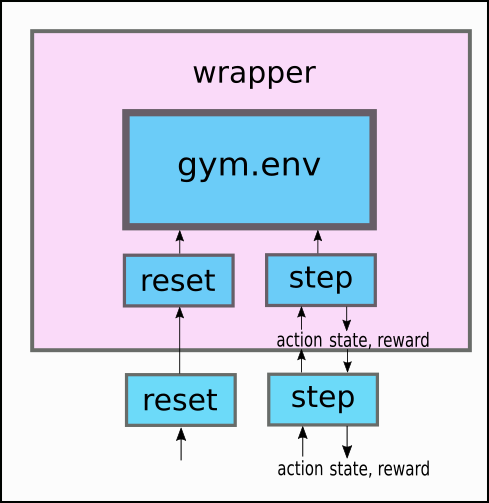

There are many wrappers that have been predefined, for a complete list refer to the [gym documentation](https://github.com/openai/gym/tree/master/gym/wrappers)

As an example, let us define a wrapper which prints the reward at each time step

In [ ]:
class RewardPrinterWrapper(gym.Wrapper):
  """
  :param env:  Gym environment that will be wrapped
  """
  def __init__(self, env: gym.Env):
    # Call the parent constructor, so we can access self.env later
    super().__init__(env)
  
  def reset(self):
    """
    Reset the environment 
    """
    obs = self.env.reset()
    return obs

  def step(self, action):
    """
    :param action: ([float] or int) Action taken by the agent
    :return: (np.ndarray, float, bool, dict) observation, reward, is the episode over?, additional informations
    """
    obs, reward, done, infos = self.env.step(action)
    print(reward)
    return obs, reward, done, infos


Now let us use it.

In [ ]:
# Create the gym Env
env = gym.make("CartPole-v1")

# Wrap the RewardPrinterWrapper around it
env = RewardPrinterWrapper(env)

# Create the RL agent
agent = PPO("MlpPolicy", env)

# Call the interaction loop
reward = evaluate_agent(agent, env)

# Print the final reward
print(reward)

 As you can see in the code above, we call the `evaluate_agent()` function without touching it, but its behavior has changed: it now prints the reward at each step.

### Wrapper Exercise (7 minutes): limit the episode length

In this exercise, the goal is to create a Gym wrapper that will limit the maximum number of steps per episode (timeout).

It will also pass a `timeout` signal in the info dict to tell the agent that the termination was due to reaching the limits.

In [ ]:
class TimeLimitWrapper(gym.Wrapper):
  """
  Limit the maximum number of steps per episode.

  :param env: Gym environment that will be wrapped
  :param max_steps: Max number of steps per episode
  """
  def __init__(self, env: gym.Env, max_steps: int = 100):
    # Call the parent constructor, so we can access self.env later
    super().__init__(env)
    self.max_steps = max_steps
    # YOUR CODE HERE
    # Counter of steps per episode

    # END OF YOUR CODE
  
  def reset(self) -> GymObs:
    # YOUR CODE HERE
    # TODO: reset the counter and reset the env

    # END OF YOUR CODE
    return obs

  def step(self, action: Union[int, np.ndarray]) -> Tuple[GymObs, float, bool, Dict]:
    # YOUR CODE HERE
    # TODO: 
    # 1. Step into the env
    # 2. Increment the episode counter
    # 3. Overwrite the done signal when time limit is reached 
    # (optional) 4. update the info dict (add a "episode_timeout" key)
    # when the episode was stopped due to timelimit

    # END OF YOUR CODE
    return obs, reward, done, infos

#### Test the wrapper

In [ ]:
from gym.envs.classic_control.pendulum import PendulumEnv

# Here we create the environment directly because gym.make() already wrap the environement in a TimeLimit wrapper otherwise
env = PendulumEnv()
# Wrap the environment
env = TimeLimitWrapper(env, max_steps=100)

In [ ]:
obs = env.reset()
done = False
n_steps = 0
while not done:
  # Take random actions
  random_action = env.action_space.sample()
  obs, reward, done, infos = env.step(random_action)
  n_steps += 1

print(f"Episode length: {n_steps} steps, info dict: {infos}")

Episode length: 100 steps, info dict: {'episode_timeout': True}


In practice, `gym` already has a wrapper for that named `TimeLimit` (`gym.wrappers.TimeLimit`) that is used by most environments.

In [ ]:
model = PPO('MlpPolicy', "CartPole-v1", verbose=1).learn(1000)

### Monitoring and logging: The Monitor wrapper and the logger

An example of wrapper provided by Stable-Baselines is the [Monitor](https://stable-baselines3.readthedocs.io/en/master/common/monitor.html?highlight=Monitor) wrapper. This wrapper stores interaction data which can then be printed by a [Logger](https://stable-baselines3.readthedocs.io/en/master/common/logger.html?highlight=Logger) or stored into files. There is a default logger inside the SB3 interaction loop.

TODO: better understand the nature of the logger and see how to integrate it in the alternative approach in the end

In [ ]:
from stable_baselines3.common.monitor import Monitor

In [ ]:
# The Monitor wrapper keeps track of the training reward and other infos (useful for plotting)
env = Monitor(env)
reward = evaluate_agent(agent, env)

In [ ]:
# Change the seed to compare to previous implementation
env.seed(42)

mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=100, deterministic=True)

print(f"mean_reward:{mean_reward:.2f} +/- {std_reward:.2f}")

## Callbacks

The callback approach is similar to the **Visitor** design pattern. In the context of SB3, it consists of two steps. First, we define an abstract `BaseCallback` class which specifies a few generic (and empty) methods. Second, we equip the core interaction loop with calls to these methods. Then, if we want to perform additional treatments in the core interaction loop, we define additional Callback classes that derive from `BaseCallback`, and we put the treatment into the overloaded methods. Finally, when calling the interaction loop, we register the callback(s) we have defined and the corresponding treatments are performed. Note that we can define a list of callbacks as a callback (this is the [CallbackList](https://stable-baselines3.readthedocs.io/en/master/guide/callbacks.html?highlight=CallbackList#callbacklist) callback), so if we pass it to the interaction loop, all callbacks in the list will be executed.

Callbacks are used to perform monitoring, auto saving, model manipulation, progress bars, etc.

A list of existing callbacks and further details about how they are define and how to define your own custom callbacks is available in the [Callbacks documentation](https://stable-baselines3.readthedocs.io/en/master/guide/callbacks.html)


Let us equip our main interaction loop with callbacks. To use all the callback functions, we need to define an outer loop that performs several episodes.

In [ ]:
from stable_baselines3.common.callbacks import BaseCallback

ModuleNotFoundError: ignored

In [ ]:
def evaluate_agent_with_callbacks(
    agent: BaseAlgorithm,
    env: gym.Env,
    deterministic: bool = False,
    callback: BaseCallback
) -> float:
    """
    Evaluate an RL agent for 1 episode.

    :param model: the RL Agent
    :param env: the gym Environment
    :param deterministic: Whether to use deterministic or stochastic actions
    :return: Mean reward for the episode.
    """

    # Retrieve first observation
    obs = env.reset()
    done = False
    total_reward = 0

    while not done:
      # The agent predicts the action to take given the observation
      action, _ = agent.predict(obs, deterministic)
      # Check that predict is properly used: we use discrete actions,
      # therefore `action` should be an int here
      assert env.action_space.contains(action)

      # The environment performs a step and produces the next state, the reward
      # and whether the episode is over 
      obs, reward, done, info = env.step(action)
      callback._on_step()
      
      # The total reward over the episode is the sum of rewards at each step
      total_reward += reward
    return total_reward


def train_with_callbacks(
    agent: BaseAlgorithm,
    env: gym.Env,
    nb_episodes: int,
    deterministic: bool = False,
    callback: BaseCallback
)-> float: #TODO check type

    # In SB3, training consists of several rollouts. Here we simplified this
    callback._on_training_start()
    reward_buffer = np.zeros(nb_episodes)
    for i in range(nb_episodes):
      callback._on_rollout_start()
      reward_buffer[i] = evaluate_agent_with_callbacks(agent, env, deterministic, callback)
      callback._on_rollout_end()

    callback._on_training_end()
    return reward_buffer.mean()


### Callbacks exercises

Although Stable-Baselines3 provides you with a callback collection (e.g. for creating checkpoints or for evaluation), we are going to re-implement some so you can get a good understanding of how they work.

To build a custom callback, you need to create a class . This will give you access to events (`_on_training_start`, `_on_step()`) and useful variables (like `self.model` for the RL model).

`_on_step` returns a boolean value for whether or not the training should continue.

Thanks to the access to the models variables, in particular `self.model`, we are able to even change the parameters of the model without halting the training, or changing the model's code.

In [ ]:
class CustomCallback(BaseCallback):
    """
    A custom callback that derives from ``BaseCallback``.

    :param verbose: (int) Verbosity level 0: not output 1: info 2: debug
    """
    def __init__(self, verbose=0):
        super(CustomCallback, self).__init__(verbose)
        # Those variables will be accessible in the callback
        # (they are defined in the base class)
        # The RL model
        # self.model = None  # type: BaseRLModel
        # An alias for self.model.get_env(), the environment used for training
        # self.training_env = None  # type: Union[gym.Env, VecEnv, None]
        # Number of time the callback was called
        # self.n_calls = 0  # type: int
        # self.num_timesteps = 0  # type: int
        # local and global variables
        # self.locals = None  # type: Dict[str, Any]
        # self.globals = None  # type: Dict[str, Any]
        # The logger object, used to report things in the terminal
        # self.logger = None  # type: logger.Logger
        # # Sometimes, for event callback, it is useful
        # # to have access to the parent object
        # self.parent = None  # type: Optional[BaseCallback]

    def _on_training_start(self) -> None:
        """
        This method is called before the first rollout starts.
        """
        pass

    def _on_rollout_start(self) -> None:
        """
        A rollout is the collection of environment interaction
        using the current policy.
        This event is triggered before collecting new samples.
        """
        pass

    def _on_step(self) -> bool:
        """
        This method will be called by the model after each call to `env.step()`.

        For child callback (of an `EventCallback`), this will be called
        when the event is triggered.

        :return: If the callback returns False, training is aborted early.
        """
        return True

    def _on_rollout_end(self) -> None:
        """
        This event is triggered before updating the policy.
        """
        pass

    def _on_training_end(self) -> None:
        """
        This event is triggered before exiting the `learn()` method.
        """
        pass

Here we have a simple callback that can only be called twice:

In [ ]:
class SimpleCallback(BaseCallback):
    """
    a simple callback that can only be called twice

    :param verbose: (int) Verbosity level 0: not output 1: info 2: debug
    """
    def __init__(self, verbose=0):
        super(SimpleCallback, self).__init__(verbose)
        self._called = False
    
    def _on_step(self):
      
      if not self._called:
        print("callback - first call")
        self._called = True
        return True # returns True, training continues.

      print("callback - second call")
      return False # returns False, training stops.      

In [ ]:
model = SAC('MlpPolicy', 'Pendulum-v0', verbose=1)
model.learn(8000, callback=SimpleCallback())

#### Exercise (8 minutes): Checkpoint Callback

In RL, it is quite useful to save checkpoints during training, as we can end up with burn-in of a bad policy. It also useful if you want to see the progression over time.

This is a typical use case for callback, as they can call the save function of the model, and observe the training over time.

In [ ]:
import os

import numpy as np

In [ ]:
class CheckpointCallback(BaseCallback):
    """
    Callback for saving a model every ``save_freq`` steps

    :param save_freq:
    :param save_path: Path to the folder where the model will be saved.
    :param name_prefix: Common prefix to the saved models
    :param verbose: Whether to print additional infos or not
    """

    def __init__(self, save_freq: int, save_path: str, name_prefix: str = "rl_model", verbose: int = 0):
        super().__init__(verbose)
        self.save_freq = save_freq
        self.save_path = save_path
        self.name_prefix = name_prefix
        # NOTE: because it derives from `BaseCallback`
        # this checkpoint callback has already access to many variables
        # like `self.model` (cf ``CustomCallback above for a complete list)

    def _init_callback(self) -> None:
        ## YOUR CODE HERE
        # Create folder if needed
        # (you may use `os.makedirs()`)

        ## END OF YOUR CODE


    def _on_step(self) -> bool:
        ## YOUR CODE HERE
        # Save the checkpoint if needed

        ## END OF YOUR CODE
        return True

Test your callback:

In [ ]:
log_dir = "/tmp/gym/"
# Create Callback
callback = CheckpointCallback(save_freq=1000, save_path="/tmp/gym/", verbose=1)

model = A2C("MlpPolicy", "CartPole-v1", verbose=1)
model.learn(total_timesteps=5000, callback=callback)

In [ ]:
!ls "/tmp/gym/"

Note: The `CheckpointCallback` as well as other [common callbacks](https://stable-baselines3.readthedocs.io/en/master/guide/callbacks.html), like the `EvalCallback` are already included in Stable-Baselines3.

In [ ]:
# Train the agent for 10000 steps
model.learn(total_timesteps=10000)

In [ ]:
# Evaluate the trained agent
mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=100)

print(f"mean_reward:{mean_reward:.2f} +/- {std_reward:.2f}")

Apparently the training went well, the mean reward increased a lot! 

## Using wrappers or callbacks ?

As you can see in the callback-equipped interaction loop above, by contrast with the wrapper approach, the callback approach requires that we insert some code into the interaction loop. Even if we are using an empty callback that does nothing, there will still be a small overhead for calling these functions, and because the interaction loop is at the heart of the RL process, this overhead matters.

Another point is that, in order to keep generic, it is necessary that all callback functions share the same signature. As a consequence, the `on_step()`, `on_rollout_end()*texte en italique*` ... functions do not take any parameter.
To compensate for that, when creating the callback we need to pass it a pointer to the information it needs to exploit, such as the RL agent, the environment, etc.

But a consequence of having no parameters in the callback functions is that they are not convenient for performing treatments that depend on data generated inside the interaction loop.

Actually, SB3 callbacks have a mechanism to store this additional information in `self.locals` and `self.globals`.

Thus a rule of thumb is that if you want to perform additional treatments on data from the interaction loop, you should better use a wrapper. This is the case with the Monitor wrapper, renormalization wrappers, etc.

By contrast, the [EvalCallback](https://stable-baselines3.readthedocs.io/en/master/guide/callbacks.html?highlight=EvalCallback#evalcallback) does not use data from the training loop, it generates its own data for evaluating the current agent.

From the other side, a wrapper is around the environment, it does not know anything about the agent, so if your treatment need to access the agent, it is better to use a callback.

**We have two reasons to prefer the wrapper model: it requires no extra code in the interaction loop at all, and it facilitates using data from the training loop. So, in many contexts, you should prefer the wrapper model. But when you need information from the agent, it is better to rely on a callback.**

# Data collection in Stable Baseline 3

In Stable Baseline 3, data collection is performed into different types of buffers, as shown in the figure below

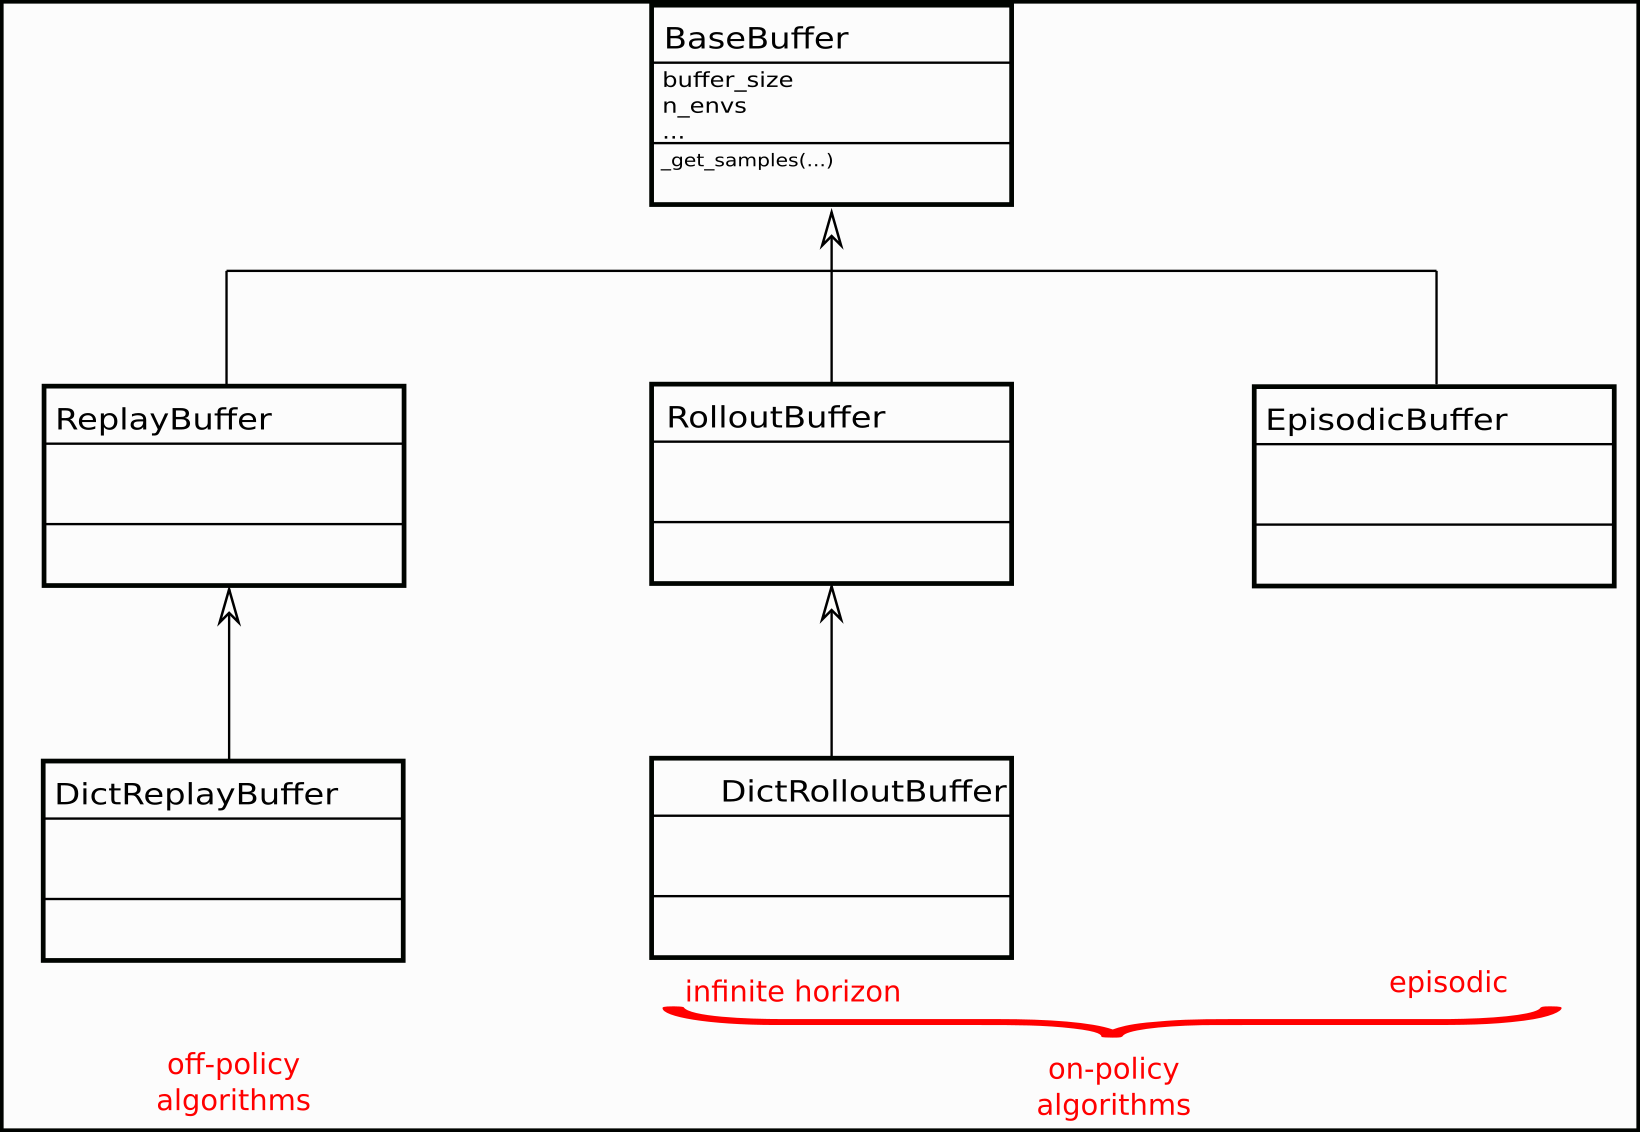

The interaction loop is the one equipped with code for calling Callback functions and it is called in the `collect_rollout()` function of the different types of RL algorithms.

### Interleaving training and evaluation episodes

When performing RL experiments, a good practice is to interleave training episodes and evaluation episodes. Indeed, evaluating an agent during a trajectory where you are training it does not make much sense, as the agent is changing along the evaluation process.

Thus SB3 separates training episodes and evaluation episodes. The global process can be depicted as follows.

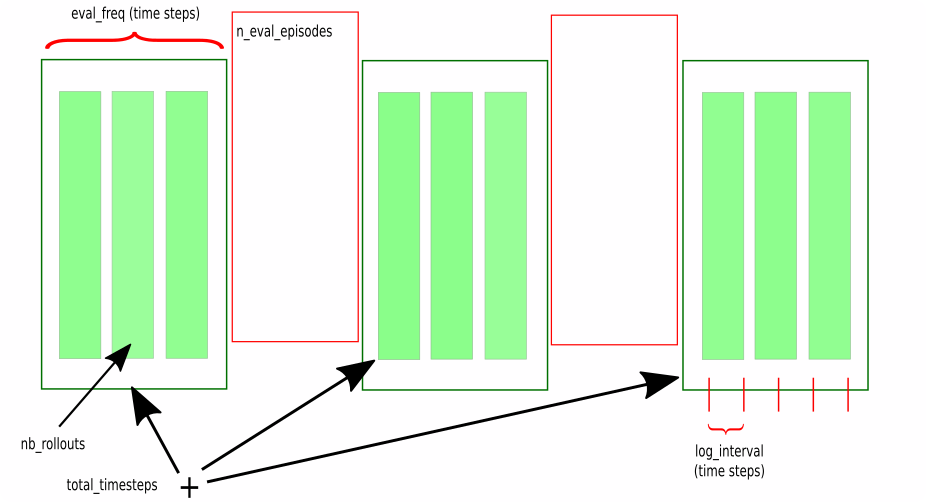

To implement this interleaving, SB3 uses the [EvalCallback](https://stable-baselines3.readthedocs.io/en/master/guide/callbacks.html?highlight=EvalCallback#evalcallback)

One important point is that evaluation episodes can be started at any time steps (in practice, once every `eval_freq` time steps). If it was called every $k$ episodes, we could have called the evaluation outside the main interaction loop, but it is not the case. Thus we definitely need a callback on each steps for checking whether we should start the evaluation.

### Critical analysis of the SB3 data collection model

The SB3 data collection model based on buffers using the callback-equipped interaction loop has several cons:
- the current SB3 implementation has an `evaluate_policy()` function corresponding to the core interaction loop untouched (that we called `evaluate_agent()` in this notebook), and several instance of the same interaction loop equipped for callbacks at several places in the code, that is in the different types of buffers
- it is not convenient to implement evolutionary methods which do not need to collect data at all steps, but just to get the final reward along trajectories. Thus evolutionary methods and agent evaluation after training should rather use the `evaluate_policy()` function.

# Conclusion

What we have seen in this notebook:
- The core interaction loop
- Gym wrappers to perform additional processes while interacting the env
- SB3 callbacks to access the RL agent
- The data collection model in SB3

